In [1]:
import os
#comment this if you are not using puffer?
os.environ['http_proxy'] = 'http://192.41.170.23:3128'
os.environ['https_proxy'] = 'http://192.41.170.23:3128'

In [2]:
#!pip install mne

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import mne
import os
import sys
from mne.datasets import eegbci
import glob
from IPython.display import clear_output
import numpy as np
import torch
from torch import nn
import torch.optim as optim

from mne.datasets import eegbci
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from scipy import signal

import torch
import torch.cuda as cuda
import torch.nn as nn
from torch.autograd import Variable

/home/nutapolt/.local/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
class EEG:
    def __init__(self, path, base_url, subjects, runs):
        self.subpath = ''
        self.path = path
        self.base_url = base_url
        self.subjects = subjects
        self.runs = runs
        
        # download data if does not exist in path.
        # self.load_data()
        self.data_to_raw()
    
    def load_data(self):
        print(f">>> Start download from: {self.base_url}.")
        print(f"Downloading files to: {self.path}.")
        for subject in self.subjects:
            eegbci.load_data(subject,self.runs,path=self.path,base_url=self.base_url)
        print("Done.")
    
    
        
        print("Done.")
        return self.raw
    def filter(self, freq):
        raw = self.raw
        low, high = freq
        print(f">>> Apply filter.")
        self.raw.filter(low, high, fir_design='firwin', verbose=20)
        return  raw
    
    def raw_ica(self):
        raw = self.raw
        ica = mne.preprocessing.ICA(n_components=64, max_iter=100)
        ica.fit(raw)
        ica.exclude = [1, 2]  # details on how we picked these are omitted here
        ica.plot_properties(raw, picks=ica.exclude)
        ica.apply(raw)
        print('ICA DONE ????')
        return  raw
        
    def get_events(self):
        event_id = dict(T1=0, T2=1) # the events we want to extract
        events, event_id = mne.events_from_annotations(self.raw, event_id=event_id)
        return events, event_id
    
    def get_epochs(self, events, event_id):
        picks = mne.pick_types(self.raw.info, eeg=True, exclude='bads')
        tmin = 0
        tmax = 4
        epochs = mne.Epochs(self.raw, events, event_id, tmin, tmax, proj=True, 
                            picks=picks, baseline=None, preload=True)
        return epochs
    
    def create_epochs(self):
        print(">>> Create Epochs.")
        events, event_id = self.get_events()
        self.epochs = self.get_epochs(events, event_id)
        return events , event_id
        
        print("Done.")
    
    def get_X_y(self):
        if self.epochs is None:
            events , event_id=self.create_epochs()
        self.X = self.epochs.get_data()
        self.y = self.epochs.events[:, -1]
        return self.X, self.y
    
    
    def data_to_raw(self):
        fullpath = os.path.join(self.path, *self.subpath.split(sep='/'))
        #print(f">>> Extract all subjects from: {fullpath}.")
        extension = "edf"
        raws = []
        count = 1
        for i, subject in enumerate(self.subjects):
            sname = f"S{str(subject).zfill(3)}".upper()
            
            for j, run in enumerate(self.runs):
                rname = f"{sname}R{str(run).zfill(2)}".upper()
                path_file = os.path.join(fullpath, sname, f'{rname}.{extension}')
                #print(path_file)
                #print(f"Loading file #{count}/{len(self.subjects)*len(self.runs)}: {f'{rname}.{extension}'}")
                raw = mne.io.read_raw_edf( path_file , preload=True, verbose='WARNING' )
                raws.append(raw)
                count += 1

        raw = mne.io.concatenate_raws(raws)
        eegbci.standardize(raw)
        montage = mne.channels.make_standard_montage('standard_1005')
        raw.set_montage(montage)
        self.raw = raw
        
        
        
def do_plot(train_loss, valid_loss,ty):
    if ty == "loss":
        plt.figure(figsize=(10,10))
        
        plt.plot(train_loss, label='train_loss')
        plt.plot(valid_loss, label='valid_loss')
        plt.title('loss {}'.format(iter))
        plt.legend()
        plt.show()
    if ty == "acc":
        plt.figure(figsize=(10,10))
        
        plot_ty=torch.tensor(train_loss, device = 'cpu')
        plat_va=torch.tensor(valid_loss, device = 'cpu')
        plt.plot(plot_ty, label='train_acc')
        plt.plot(plat_va, label='valid_acc')
        plt.title('acc {}'.format(iter))
        plt.legend()
        plt.show()

Raw done
>>> Apply filter.
Filtering raw data in 237 contiguous segments
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 529 samples (3.306 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished


Filter done
Fitting ICA to data using 64 channels (please be patient, this may take a while)


/tmp/ipykernel_298/3475720647.py:34: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)


Selecting by number: 64 components


/home/nutapolt/.local/lib/python3.8/site-packages/sklearn/decomposition/_fastica.py:120: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


Fitting ICA took 954.0s.
    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
62 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
62 matching events found
No baseline correction applied
0 projection items activated


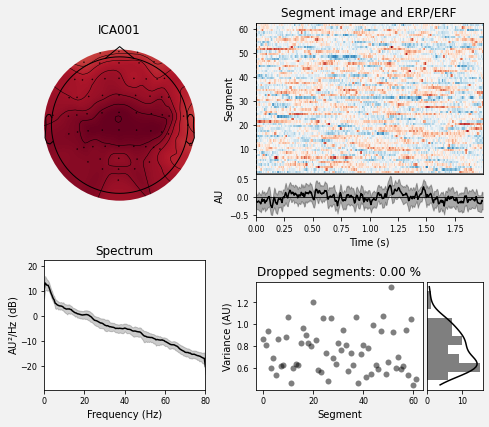

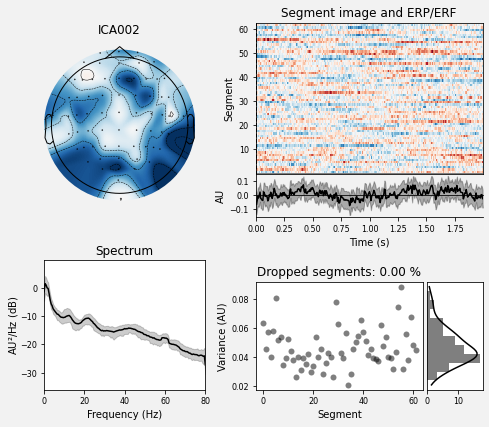

Applying ICA to Raw instance
    Transforming to ICA space (64 components)
    Zeroing out 2 ICA components
    Projecting back using 64 PCA components
ICA DONE ????
>>> Create Epochs.
Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
3555 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 3555 events and 641 original time points ...
16 bad epochs dropped


(array([[    672,       0,       1],
        [   2000,       0,       0],
        [   3328,       0,       0],
        ...,
        [4676928,       0,       1],
        [4678256,       0,       0],
        [4679584,       0,       1]]),
 {'T1': 0, 'T2': 1})

In [7]:
# home directory + datasets folder
#path = '/content/drive/MyDrive/MNE-eegbci-data/files/eegmmidb/'
path = 'physionet.org/files/eegmmidb/1.0.0'
base_url = 'https://physionet.org/files/eegmmidb/'
# subjects = [1]
#runs = [3, 4, 7, 8, 11, 12]
runs = [4, 8, 12]
subjects = [i for i in range(1,80)]
#subjects = [1]
# runs = [6,10,14]

eeg = EEG(path, base_url, subjects, runs)
raw=eeg.data_to_raw()
print("Raw done")
# apply filter
freq = (1., 40.)
raw=eeg.filter(freq=freq)
raw=eeg.data_to_raw()
print("Filter done")
raw=eeg.raw_ica()
eeg.create_epochs()

In [8]:
X, y = eeg.get_X_y()

print(X.shape, y.shape)
X = X[:,:,:]
X.shape

(3539, 64, 641) (3539,)


(3539, 64, 641)

In [9]:
# pick 7 channels.
#X2 = X[:, :14, :]
# = X2

# pick C3 and C4 channels.
X2 = X[:, 1:2, :] 
X3= X[:, 5:6, :]
X = np.concatenate((X2,X3), axis=1)
# = X4
#X = X[:, :,np.newaxis,:]
print(X.shape)

(3539, 2, 641)


In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

print('train size',X_train.shape, y_train.shape)
print('Test size',X_test.shape, y_test.shape)

train size (2477, 2, 641) (2477,)
Test size (1062, 2, 641) (1062,)


In [11]:
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

batch_size = 32

def create_dataloader(X, y, batch_size):
    X_tensor = torch.tensor(X).float()
    y_tensor = torch.tensor(y).long()
    dataset_tensor = TensorDataset(X_tensor, y_tensor)
    dl = torch.utils.data.DataLoader(dataset_tensor, batch_size=batch_size, shuffle=True)
    return dl
train_loader = create_dataloader(X_train, y_train, batch_size=batch_size)
test_loader = create_dataloader(X_test, y_test, batch_size=batch_size)

In [12]:
# Convolutional neural network (two convolutional layers)
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        
        #using sequential helps bind multiple operations together
        self.layer1 = nn.Sequential(
            #padding = (kernel_size - 1) / 2 = 2
            nn.Conv1d(2, 64, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            # nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.layer2 = nn.Sequential(
            nn.Conv1d(64, 128, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            # nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.fc = nn.Linear(82048, 2)
        self.drop_out = nn.Dropout(0.5)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.drop_out(out)
        out = self.layer2(out)
        out = self.drop_out(out)
        out = out.reshape(out.size(0), -1)   #can also use .view()
        out = self.fc(out)
        return out

In [13]:
class gamenet(nn.Module):
    def __init__(self):
        
        super(gamenet,self).__init__()
        
        self.l1 = nn.Sequential(
            #in_channel = 16
            #out_channel or Filter size = 100
            #kernel size = (1,25)
            #stride = 1
            #padding = Same
            #Relu
            nn.Conv2d(2,100,kernel_size=(1,25),stride=1,padding='same'),
            nn.ReLU(),
            nn.BatchNorm2d(100)
        )
        self.l2 = nn.Sequential(
            #in_channel = 100
            #out_channel or Filter size = 100
            #kernel size = (16,1)
            #stride = 1
            #padding = Valid
            #Relu
            nn.Conv2d(100,100,kernel_size=(1,16),stride=1,padding='valid'),
            #nn.Conv2d(100,100,kernel_size=(64,1),stride=1,padding='valid'),
            nn.ReLU(),
            nn.BatchNorm2d(100)
        )
        self.l3 = nn.Sequential(
            #in_channel = 100
            #out_channel = 50
            #kernel size = (1,30)
            #stride = 1
            #padding = Same
            #Relu
            nn.Conv2d(100,50,kernel_size=(1,30),stride=1,padding='same'),
            nn.ReLU(),
            nn.BatchNorm2d(50)
        )
        self.maxpooling1 = nn.MaxPool2d(kernel_size=(1,7),stride=5)
        self.l4 = nn.Sequential(
            #in_channel = 50
            #out_channel = 50
            #kernel size = (1,30)
            #stride = 1
            #padding = Same
            #Relu
            nn.Conv2d(50,50,kernel_size=(1,30),stride=1,padding='same'),
            nn.ReLU(),
            nn.BatchNorm2d(50)
        )
        self.maxpooling2 = nn.MaxPool2d(kernel_size=(1,3),stride=2)
        

        self.flatten = nn.Sequential(
            nn.Flatten(),
            nn.BatchNorm1d(3050),
            nn.Dropout(0.15)
        )
        self.fc1 = nn.Sequential(
            nn.Linear(3050,1024),
            nn.ReLU(),
            nn.BatchNorm1d(1024),
            nn.Dropout(0.15)
        )
        self.fc2 = nn.Sequential(
            nn.Linear(1024,512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(0.15)
        )
        self.fc3 = nn.Sequential(
            nn.Linear(512,256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(0.15)
        )
        self.fc3 = nn.Sequential(
            nn.Linear(512,256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(0.15)
        )
        self.fc4 = nn.Sequential(
            nn.Linear(256,128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.15)
        )
        self.fc5 = nn.Sequential(
            nn.Linear(128,64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Dropout(0.15)
        )
        self.fc6 = nn.Sequential(
            nn.Linear(64,32),
            nn.ReLU(),
            nn.BatchNorm1d(32),
            nn.Dropout(0.15)
        )
        self.softmax = nn.Sequential(
            nn.Linear(32,4),
            nn.Softmax()
        )
    def forward(self,x):
        
        out = self.l1(x)
        out = self.l2(out)
        out = self.l3(out)
        out = self.maxpooling1(out)
        out = self.l4(out)
        out = self.maxpooling2(out)
        out = self.flatten(out)
        out = self.fc1(out)
        out = self.fc2(out)
        out = self.fc3(out)
        out = self.fc4(out)
        out = self.fc5(out)
        out = self.fc6(out)
        out = self.softmax(out)
        return out

In [17]:
net = ConvNet().cuda(0)

In [18]:
# Loss and optimizer
optimizer = optim.Adam(net.parameters(), lr=0.0000001)
criterion = nn.CrossEntropyLoss()

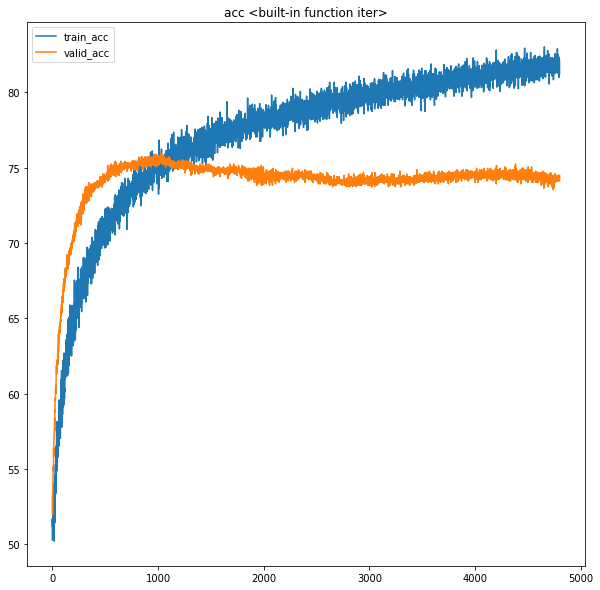

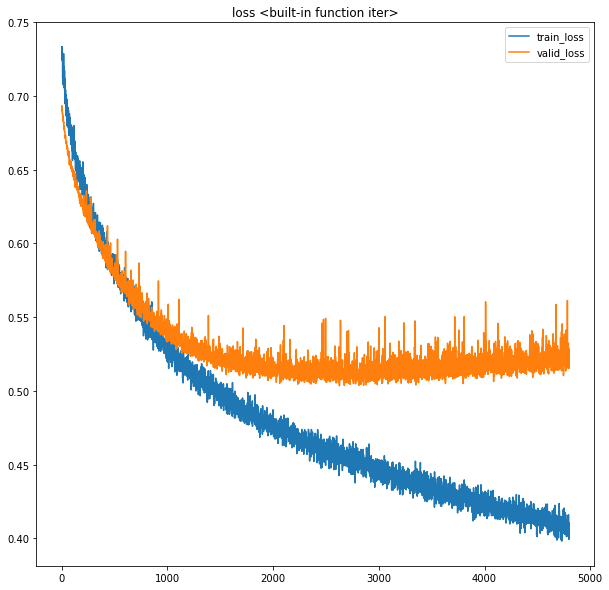

Epoch 4851/5000, Tr Loss: 0.4034, Tr Acc: 82.3981, Val Loss: 0.5148, Val Acc: 74.1055
Epoch 4951/5000, Tr Loss: 0.4040, Tr Acc: 81.6714, Val Loss: 0.5237, Val Acc: 74.2938
Epoch 5000/5000, Tr Loss: 0.4071, Tr Acc: 81.2273, Val Loss: 0.5313, Val Acc: 74.5763


In [19]:
# Train the model
num_epochs = 5000

train_loss = []
valid_loss = []
train_accuracy = []
valid_accuracy = []
old_acc = 0
for epoch in range(num_epochs):
    iter_loss = 0.0
    correct = 0
    iterations = 0
    
    net.train()
    
    for i, (items, classes) in enumerate(train_loader):
        items = Variable(items)
        classes = Variable(classes)
        
        if cuda.is_available():
            items = items.cuda(0)
            classes = classes.cuda(0)
        
        optimizer.zero_grad()
        outputs = net(items)
        loss = criterion(outputs, classes)
        #print(outputs)
        iter_loss += loss.item()
        loss.backward()
        optimizer.step()
        #print(loss)
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == classes.data).sum()
        iterations += 1

    train_loss.append(iter_loss/iterations)
    
    train_accuracy.append((100 * correct.float() / len(train_loader.dataset)))
    
    loss = 0.0
    correct = 0
    iterations = 0
    net.eval()
    
    for i, (items, classes) in enumerate(test_loader):
        items = Variable(items)
        classes = Variable(classes)
        
        if cuda.is_available():
            items = items.cuda(0)
            classes = classes.cuda(0)
        
        outputs = net(items)
        loss += criterion(outputs, classes).item()
        
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == classes.data).sum()
        
        iterations += 1

    valid_loss.append(loss/iterations)
    correct_scalar = np.array([correct.clone().cpu()])[0]
    valid_accuracy.append(correct_scalar / len(test_loader.dataset) * 100.0)
    if valid_accuracy[-1] > old_acc :
        torch.save(net.state_dict(), 'model_2class_2ch_CNN_ica')
        old_acc = valid_accuracy[-1]
    if (epoch%50) == 0 :
        print ('Epoch %d/%d, Tr Loss: %.4f, Tr Acc: %.4f, Val Loss: %.4f, Val Acc: %.4f'
                   %(epoch+1, num_epochs, train_loss[-1], train_accuracy[-1], valid_loss[-1], valid_accuracy[-1]))
    if (epoch%300) == 0:
        clear_output(wait=True)
        do_plot(train_accuracy, valid_accuracy,"acc")
        do_plot(train_loss, valid_loss,"loss")
        
print ('Epoch %d/%d, Tr Loss: %.4f, Tr Acc: %.4f, Val Loss: %.4f, Val Acc: %.4f'
                   %(epoch+1, num_epochs, train_loss[-1], train_accuracy[-1], valid_loss[-1], valid_accuracy[-1]))


In [23]:
print ('Epoch %d/%d, Tr Loss: %.4f, Tr Acc: %.4f, Val Loss: %.4f, Val Acc: %.4f'
                   %(epoch+1, num_epochs, train_loss[-1], train_accuracy[-1], valid_loss[-1], valid_accuracy[-1]))


Epoch 5000/5000, Tr Loss: 0.4071, Tr Acc: 81.2273, Val Loss: 0.5313, Val Acc: 74.5763


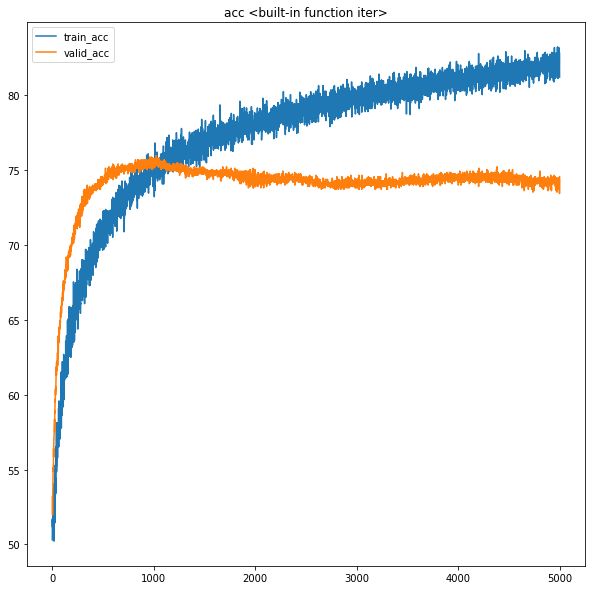

In [24]:
do_plot(train_accuracy, valid_accuracy,"acc")

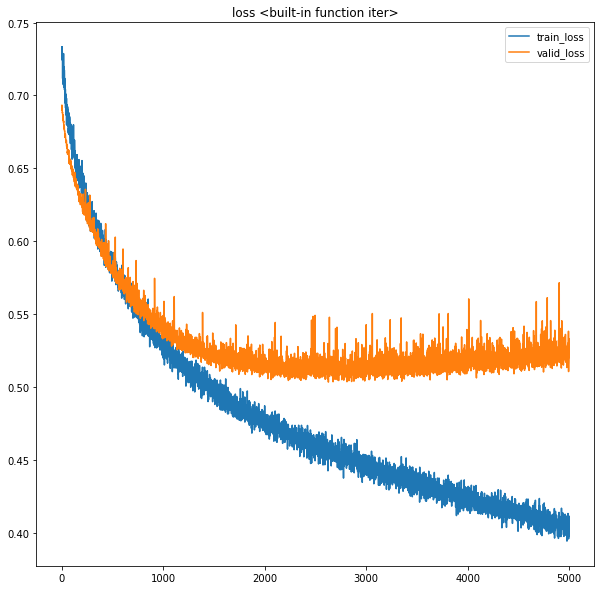

In [25]:
do_plot(train_loss, valid_loss,"loss")

### validate


In [26]:
del net
net = ConvNet().cuda(0)

In [27]:
net.load_state_dict(torch.load('model_2class_2ch_CNN_ica'))

<All keys matched successfully>

Raw done
>>> Apply filter.
Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 529 samples (3.306 sec)

Filter done
Fitting ICA to data using 64 channels (please be patient, this may take a while)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.0s finished


Selecting by number: 64 components
Fitting ICA took 16.6s.
    Using multitaper spectrum estimation with 7 DPSS windows


/home/nutapolt/.local/lib/python3.8/site-packages/sklearn/decomposition/_fastica.py:120: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


Not setting metadata
62 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
62 matching events found
No baseline correction applied
0 projection items activated


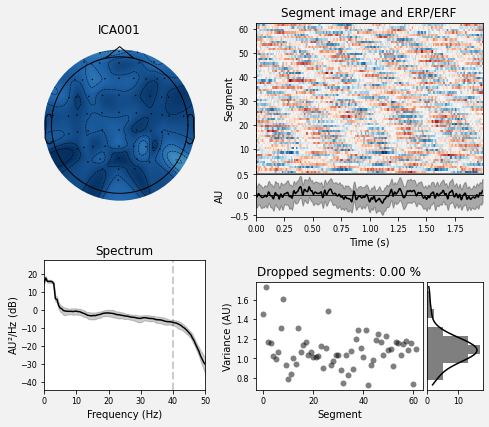

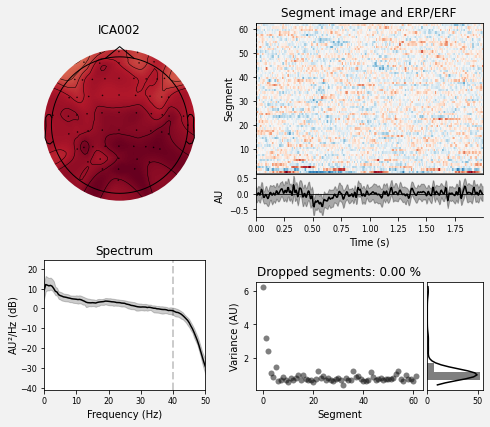

Applying ICA to Raw instance
    Transforming to ICA space (64 components)
    Zeroing out 2 ICA components
    Projecting back using 64 PCA components
ICA DONE ????
>>> Create Epochs.
Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
45 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 45 events and 641 original time points ...
0 bad epochs dropped


(array([[  672,     0,     0],
        [ 2000,     0,     1],
        [ 3328,     0,     1],
        [ 4656,     0,     0],
        [ 5984,     0,     0],
        [ 7312,     0,     1],
        [ 8640,     0,     1],
        [ 9968,     0,     0],
        [11296,     0,     1],
        [12624,     0,     0],
        [13952,     0,     1],
        [15280,     0,     0],
        [16608,     0,     1],
        [17936,     0,     0],
        [19264,     0,     0],
        [20672,     0,     0],
        [22000,     0,     1],
        [23328,     0,     0],
        [24656,     0,     1],
        [25984,     0,     1],
        [27312,     0,     0],
        [28640,     0,     0],
        [29968,     0,     1],
        [31296,     0,     1],
        [32624,     0,     0],
        [33952,     0,     1],
        [35280,     0,     0],
        [36608,     0,     1],
        [37936,     0,     0],
        [39264,     0,     1],
        [40672,     0,     0],
        [42000,     0,     1],
        

In [28]:
# home directory + datasets folder
#path = '/content/drive/MyDrive/MNE-eegbci-data/files/eegmmidb/'
path = 'physionet.org/files/eegmmidb/1.0.0'
base_url = 'https://physionet.org/files/eegmmidb/'
# subjects = [1]
#runs = [3, 4, 7, 8, 11, 12]
runs = [4, 8, 12]
subjects = [i for i in range(83,84)]
#subjects = [1]
# runs = [6,10,14]

eeg = EEG(path, base_url, subjects, runs)
raw=eeg.data_to_raw()
print("Raw done")
# apply filter
freq = (1., 40.)
raw=eeg.filter(freq=freq)
#raw=eeg.data_to_raw()
print("Filter done")
raw=eeg.raw_ica()
eeg.create_epochs()

In [33]:
# pick 7 channels.
#X2 = X[:, :14, :]
# = X2

# pick C3 and C4 channels.

X_val, y_val = eeg.get_X_y()

X2 = X_val[:, 1:2, :] 
X3= X_val[:, 5:6, :]
X_val = np.concatenate((X2,X3), axis=1)
# = X4
#X_val = X_val[:, :,np.newaxis,:]
print(X_val.shape)




(45, 2, 641)


In [34]:
test_loader = create_dataloader(X_val, y_val, batch_size=batch_size)

In [35]:
# Train the model
num_epochs = 1

train_loss = []
valid_loss = []
train_accuracy = []
valid_accuracy = []
old_acc = 0
for epoch in range(num_epochs):

    loss = 0.0
    correct = 0
    iterations = 0
    net.eval()
    for i, (items, classes) in enumerate(test_loader):
        items = Variable(items)
        classes = Variable(classes)
        
        if cuda.is_available():
            items = items.cuda(0)
            classes = classes.cuda(0)
        
        outputs = net(items)
        loss += criterion(outputs, classes).item()
        
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == classes.data).sum()
        
        iterations += 1

    valid_loss.append(loss/iterations)
    correct_scalar = np.array([correct.clone().cpu()])[0]
    valid_accuracy.append(correct_scalar / len(test_loader.dataset) * 100.0)
print (' Val Acc: %.4f'
                   %(valid_accuracy[-1]))


 Val Acc: 51.1111


### Freeze layer

In [48]:
del net
net = ConvNet().cuda(0)

In [49]:
net.load_state_dict(torch.load('model_2class_2ch_CNN_ica'))

<All keys matched successfully>

In [ ]:
net

In [38]:
parms = net.state_dict()
parms.keys()

odict_keys(['layer1.0.weight', 'layer1.0.bias', 'layer1.1.weight', 'layer1.1.bias', 'layer1.1.running_mean', 'layer1.1.running_var', 'layer1.1.num_batches_tracked', 'layer2.0.weight', 'layer2.0.bias', 'layer2.1.weight', 'layer2.1.bias', 'layer2.1.running_mean', 'layer2.1.running_var', 'layer2.1.num_batches_tracked', 'fc.weight', 'fc.bias'])

In [39]:
for name,param in net.named_parameters():
    if param.requires_grad and 'layer1' in name:
        param.requires_grad = False
    if param.requires_grad and 'layer2' in name:
        param.requires_grad = False

Raw done
>>> Apply filter.
Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 529 samples (3.306 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.0s finished


Filter done
Fitting ICA to data using 64 channels (please be patient, this may take a while)


/tmp/ipykernel_298/3475720647.py:34: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)


Selecting by number: 64 components
Fitting ICA took 10.0s.
    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
62 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
62 matching events found
No baseline correction applied
0 projection items activated


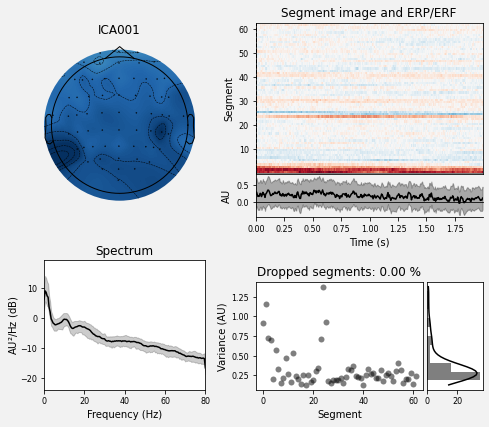

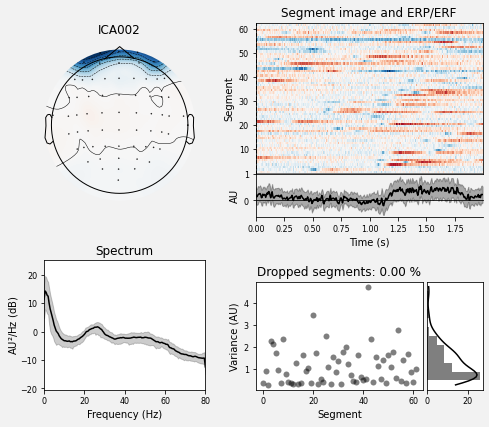

Applying ICA to Raw instance
    Transforming to ICA space (64 components)
    Zeroing out 2 ICA components
    Projecting back using 64 PCA components
ICA DONE ????
>>> Create Epochs.
Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
45 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 45 events and 641 original time points ...
0 bad epochs dropped


(array([[  672,     0,     0],
        [ 2000,     0,     1],
        [ 3328,     0,     1],
        [ 4656,     0,     0],
        [ 5984,     0,     0],
        [ 7312,     0,     1],
        [ 8640,     0,     1],
        [ 9968,     0,     0],
        [11296,     0,     1],
        [12624,     0,     0],
        [13952,     0,     1],
        [15280,     0,     0],
        [16608,     0,     1],
        [17936,     0,     0],
        [19264,     0,     0],
        [20672,     0,     0],
        [22000,     0,     1],
        [23328,     0,     0],
        [24656,     0,     1],
        [25984,     0,     1],
        [27312,     0,     0],
        [28640,     0,     0],
        [29968,     0,     1],
        [31296,     0,     1],
        [32624,     0,     0],
        [33952,     0,     1],
        [35280,     0,     0],
        [36608,     0,     1],
        [37936,     0,     0],
        [39264,     0,     1],
        [40672,     0,     0],
        [42000,     0,     1],
        

In [41]:
# home directory + datasets folder
#path = '/content/drive/MyDrive/MNE-eegbci-data/files/eegmmidb/'
path = 'physionet.org/files/eegmmidb/1.0.0'
base_url = 'https://physionet.org/files/eegmmidb/'
# subjects = [1]
#runs = [3, 4, 7, 8, 11, 12]
runs = [4, 8, 12]
subjects = [i for i in range(83,84)]
#subjects = [1]
# runs = [6,10,14]

eeg = EEG(path, base_url, subjects, runs)
raw=eeg.data_to_raw()
print("Raw done")
# apply filter
freq = (1., 40.)
raw=eeg.filter(freq=freq)
raw=eeg.data_to_raw()
print("Filter done")
raw=eeg.raw_ica()
eeg.create_epochs()

In [42]:
X, y = eeg.get_X_y()

print(X.shape, y.shape)

X = X[:,:,:]
X.shape

(45, 64, 641) (45,)


(45, 64, 641)

In [43]:
# pick 7 channels.
#X2 = X[:, :14, :]
# = X2

# pick C3 and C4 channels.
X2 = X[:, 1:2, :] 
X3= X[:, 5:6, :]
X = np.concatenate((X2,X3), axis=1)
# = X4
#X = X[:, :,np.newaxis,:]
print(X.shape)

(45, 2, 641)


In [44]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

X_test, X_vail, y_test, y_vail = train_test_split(X_test, y_test, test_size=0.3)

print(X_test.shape, y_test.shape)
print(X_vail.shape, y_vail.shape)

(31, 2, 641) (31,)
(14, 2, 641) (14,)
(9, 2, 641) (9,)
(5, 2, 641) (5,)


In [45]:
train_loader = create_dataloader(X_train, y_train, batch_size=batch_size)
test_loader = create_dataloader(X_test, y_test, batch_size=batch_size)

In [51]:
optimizer = optim.Adam(filter(lambda p: p.requires_grad, net.parameters()),lr=0.00001)
#optimizer = optim.SGD(filter(lambda p: p.requires_grad, net.parameters()), lr=0.00001)
#optimizer = optim.Adam(net.parameters(), lr=0.0000001)
criterion = nn.CrossEntropyLoss()

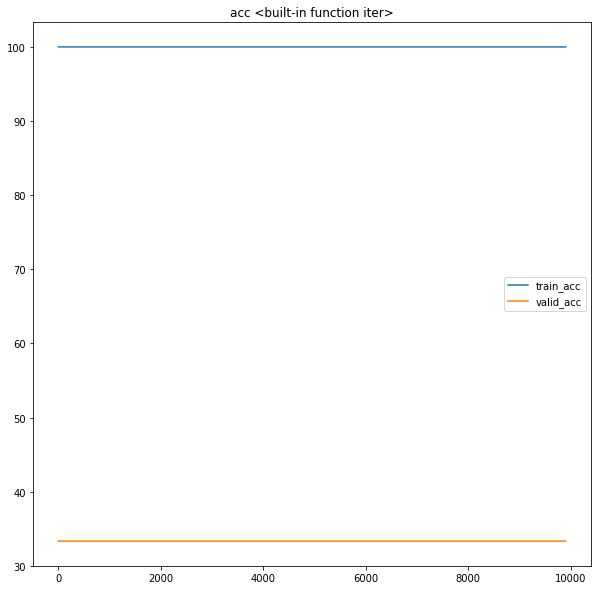

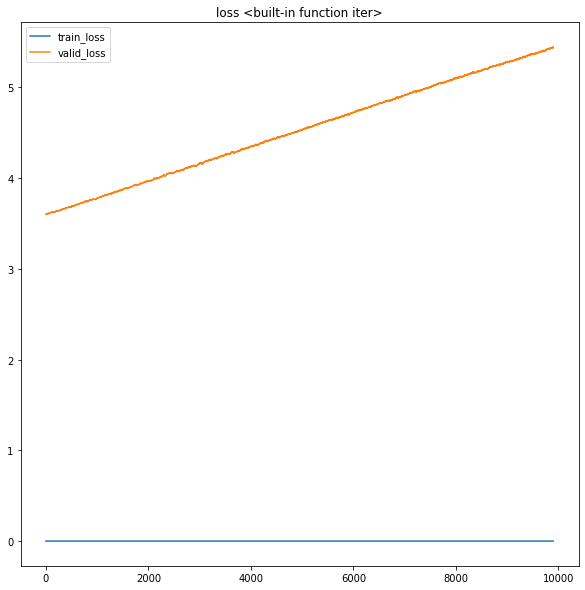

Epoch 9951/10000, Tr Loss: 0.0000, Tr Acc: 100.0000, Val Loss: 5.4444, Val Acc: 33.3333
Epoch 10000/10000, Tr Loss: 0.0000, Tr Acc: 100.0000, Val Loss: 5.4555, Val Acc: 33.3333


In [53]:
# Train the model
num_epochs = 10000

train_loss = []
valid_loss = []
train_accuracy = []
valid_accuracy = []
old_acc = 0
for epoch in range(num_epochs):
    iter_loss = 0.0
    correct = 0
    iterations = 0
    
    net.train()
    
    for i, (items, classes) in enumerate(train_loader):
        items = Variable(items)
        classes = Variable(classes)
        
        if cuda.is_available():
            items = items.cuda(0)
            classes = classes.cuda(0)
        
        optimizer.zero_grad()
        outputs = net(items)
        loss = criterion(outputs, classes)
        #print(outputs)
        iter_loss += loss.item()
        loss.backward()
        optimizer.step()
        #print(loss)
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == classes.data).sum()
        iterations += 1

    train_loss.append(iter_loss/iterations)
    
    train_accuracy.append((100 * correct.float() / len(train_loader.dataset)))
    
    loss = 0.0
    correct = 0
    iterations = 0
    net.eval()
    
    for i, (items, classes) in enumerate(test_loader):
        items = Variable(items)
        classes = Variable(classes)
        
        if cuda.is_available():
            items = items.cuda(0)
            classes = classes.cuda(0)
        
        outputs = net(items)
        loss += criterion(outputs, classes).item()
        
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == classes.data).sum()
        
        iterations += 1

    valid_loss.append(loss/iterations)
    correct_scalar = np.array([correct.clone().cpu()])[0]
    valid_accuracy.append(correct_scalar / len(test_loader.dataset) * 100.0)
    if valid_accuracy[-1] > old_acc :
        torch.save(net.state_dict(), 'model_find_tune_2class_2ch_ica')
        old_acc = valid_accuracy[-1]
    if (epoch%50) == 0 :
        print ('Epoch %d/%d, Tr Loss: %.4f, Tr Acc: %.4f, Val Loss: %.4f, Val Acc: %.4f'
                   %(epoch+1, num_epochs, train_loss[-1], train_accuracy[-1], valid_loss[-1], valid_accuracy[-1]))
    if (epoch%300) == 0:
        clear_output(wait=True)
        do_plot(train_accuracy, valid_accuracy,"acc")
        do_plot(train_loss, valid_loss,"loss")
        
print ('Epoch %d/%d, Tr Loss: %.4f, Tr Acc: %.4f, Val Loss: %.4f, Val Acc: %.4f'
                   %(epoch+1, num_epochs, train_loss[-1], train_accuracy[-1], valid_loss[-1], valid_accuracy[-1]))


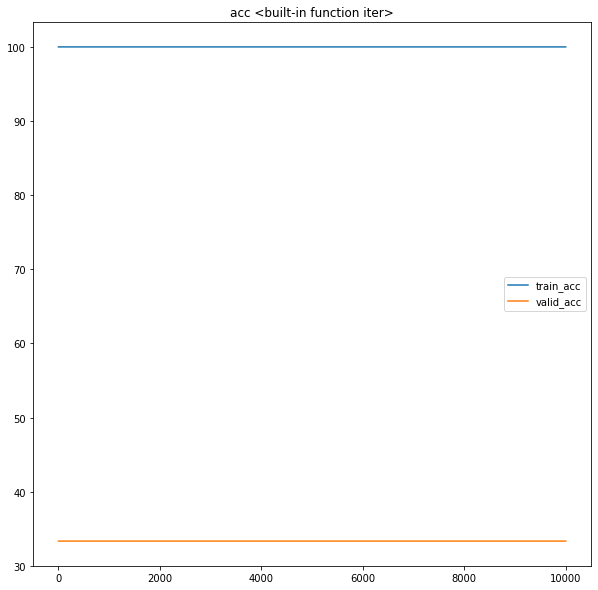

In [54]:
do_plot(train_accuracy, valid_accuracy,"acc")

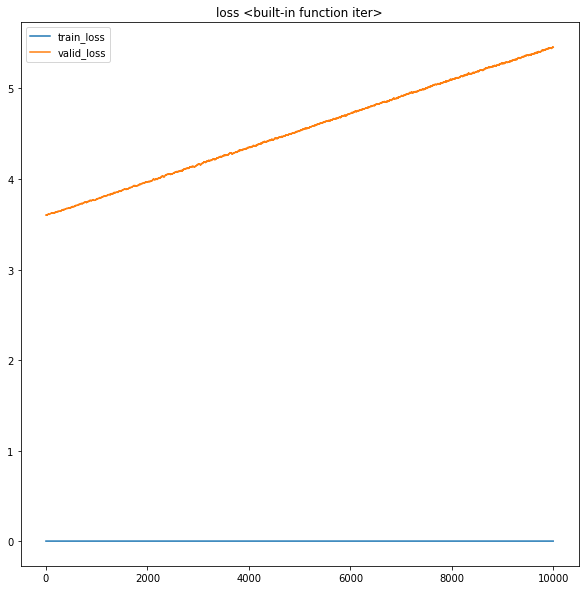

In [55]:
do_plot(train_loss, valid_loss,"loss")

### Validate Findtune

In [56]:
del net

In [57]:
net = ConvNet().cuda(0)

In [58]:
net.load_state_dict(torch.load('model_find_tune_2class_2ch_ica'))

<All keys matched successfully>

In [59]:
test_loader = create_dataloader(X_vail, y_vail, batch_size=batch_size)


In [60]:
# Train the model
num_epochs = 1

train_loss = []
valid_loss = []
train_accuracy = []
valid_accuracy = []
old_acc = 0
for epoch in range(num_epochs):

    loss = 0.0
    correct = 0
    iterations = 0
    net.eval()
    for i, (items, classes) in enumerate(test_loader):
        items = Variable(items)
        classes = Variable(classes)
        
        if cuda.is_available():
            items = items.cuda(0)
            classes = classes.cuda(0)
        
        outputs = net(items)
        loss += criterion(outputs, classes).item()
        
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == classes.data).sum()
        
        iterations += 1

    valid_loss.append(loss/iterations)
    correct_scalar = np.array([correct.clone().cpu()])[0]
    valid_accuracy.append(correct_scalar / len(test_loader.dataset) * 100.0)
print (' Val Acc: %.4f'
                   %(valid_accuracy[-1]))


 Val Acc: 60.0000


In [61]:
y_vail

array([1, 1, 1, 0, 1])